In [14]:
import os
from pydantic import BaseModel
from typing import List
from langchain_core.documents import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph,START,END


In [15]:
from langchain_community.document_loaders import TextLoader


In [16]:
docs=TextLoader("research_notes.txt",encoding="utf-8").load()
splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50)
chunk=splitter.split_documents(docs)


In [17]:
embeddings=HuggingFaceEmbeddings()

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 632.17it/s, Materializing param=pooler.dense.weight]                        
MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [18]:
vectorstore=FAISS.from_documents(chunk,embedding=embeddings)
retriever=vectorstore.as_retriever()

In [19]:
retriever

VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000001EE8826EF00>, search_kwargs={})

In [20]:
import os
from langchain_groq.chat_models import ChatGroq
os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")
from dotenv import load_dotenv
load_dotenv()

True

In [21]:
llm=ChatGroq(model='openai/gpt-oss-120b')

In [22]:
llm.invoke("Hi").content

'Hello! How can I help you today?'

In [23]:
#mKAING TH  SUBDIFIVISON  OF THE QUESTIONS THAT ARE PRESENT IN HERE
class RAGTOSTATE(BaseModel):
    questions:str
    sub_steps:List[str]=[]
    retrieved_docs:List[Document]=[]
    answer:str=""

In [25]:
def plan_steps(state:RAGTOSTATE)->RAGTOSTATE:
    prompt=f"Break The questions into 2-3 resoning steps: \n\n {state.question}"
    result=llm.invoke(prompt).content
    subsq=[line.strip("-  ") for line in result.split("\n") if line.strip()]
    return state.model_copy(update={"retrieved_docs":all_docs})

In [26]:
def generate_answer(state:RAGTOSTATE)->RAGTOSTATE:
    context="\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt=f"""
    You are answering a complex question using reasoing ansd retrieved documents

    Question:{state.question}
    Relvant Information:
    {context}
    Now syntehsize a well reasoned final  answer
    """
    result=llm.invoke(prompt).content.strip()
    return  state.model_copy(update={"answer":result})

In [33]:
builder=StateGraph(RAGTOSTATE)
builder.add_node("planner",plan_steps)
builder.add_node("retrieved",retriever)
builder.add_node('responder',generate_answer)

builder.set_entry_point('planner')
builder.add_edge("planner","retrieved")
builder.add_edge("retrieved","responder")
builder.add_edge("responder",END)

graph=builder.compile()

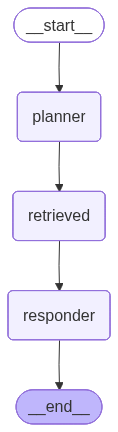

In [34]:
graph